In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
import astropy.units as u

In [2]:
table = Table.read('data/target_list_saintex_sel.csv', delimiter=';')

In [95]:
np.random.seed(1984)

# Fraction that have planets: 100%
table['inclination'] = 90 * np.random.rand(len(table))
table['period'] = 1.6 * u.day
table['epoch'] = 1000 * np.random.rand() + Time('2020-01-01').jd

In [96]:
target = table[table['spc'] == "Sp1428+3310"]

In [162]:
target_jmag = target['jmag'].data[0]

In [166]:
# plt.subplot(111, projection="mollweide")
# n_points = 100
# # [-pi, pi], [pi/2, pi/2]?
# # plt.scatter(2 * np.pi * (np.random.rand(n_points) - 0.5), np.pi*(np.random.rand(n_points) - 0.5))
# plt.scatter(np.radians(table['ra_deg']) - np.pi, np.radians(table['dec_deg']))

In [99]:
import astropy.units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astroplan import Observer, FixedTarget, AirmassConstraint, AtNightConstraint, is_observable
from astropy.time import Time

times = Time('2020-01-01') + np.arange(0, 365, 10/60/24)*u.day

coords = SkyCoord(ra=table['ra_deg']*u.deg, dec=table['dec_deg']*u.deg)

targets = [FixedTarget(coord=c, name=name) for c, name in zip(coords, table['spc'])]

loc = EarthLocation.from_geodetic(-115.5681*u.deg, 30.8669*u.deg, height=1000*u.m)

saintex = Observer(location=loc)

In [106]:
from glob import glob
lc_paths = glob('data/npy/*.npy')

In [126]:
real_lcs = [np.load(p) for p in lc_paths]

# Two-hour each strategy: 

In [102]:
from batman import TransitModel, TransitParams
from astropy.constants import R_earth, R_sun, M_sun, G

M_star = 0.1 * M_sun
R_star = 0.12 * R_sun
params = TransitParams()
params.per = 1.6
params.rp = float(R_earth/R_star)
params.limb_dark = 'quadratic'
params.u = [1.0, 0.0]  # Luger 2017
params.w = 90
params.ecc = 0
params.a = float(((G*M_star*(params.per*u.day)**2)/(4*np.pi**2))**(1/3) / R_star)

In [173]:
from astroplan import time_grid_from_range, observability_table

n_objects_per_night = 5
airmass_cutoff = 3.5
fraction_cloudy = 0.3
n_years = 2
n_trials = 10

constraints = [AtNightConstraint.twilight_nautical(), 
               AirmassConstraint(max=airmass_cutoff)]

start_time = Time('2020-01-01 08:00')  # near local midnight
end_time = Time('2021-01-01 08:00') # near local midnight

n_transits = []

target_inds_observed = set([])

obs_database = {name: dict(times=[], fluxes=[], model=[], transit=False) for name in table['spc']}

for i in range(n_years*365): 
    # Simulate weather losses
    if np.random.rand() > fraction_cloudy: 
        time = start_time + i*u.day
        night_start = saintex.twilight_evening_nautical(time, which='previous')
        night_end = saintex.twilight_morning_nautical(time, which='next')
        night_duration = night_end - night_start

        times = time_grid_from_range((night_start, night_end), time_resolution=1.6*u.min)

        obs_table = observability_table(constraints, saintex, targets, times=times)

        mask_targets_visible_2hrs = obs_table['fraction of time observable']*night_duration > 2*u.hr

        object_inds_to_observe = np.random.choice(np.argwhere(mask_targets_visible_2hrs)[:, 0], size=n_objects_per_night)

        target_inds_observed.update(object_inds_to_observe)

        # Split the night evenly into N chunks
        try: 
            split_times = np.split(times, n_objects_per_night)
        except ValueError: 
            split_times = np.split(times[len(times)%n_objects_per_night:], n_objects_per_night)

        for i, ind in enumerate(object_inds_to_observe):
            obs_times = split_times[i].jd
            target_name = table['spc'][ind]
            params.inc = table['inclination'][ind]
            params.t0 = table['epoch'][ind]
            transit_model = TransitModel(params, obs_times).light_curve(params)

            # Only save LCs containing transits
            if transit_model.min() < 1:
                random_night = np.random.randint(0, len(real_lcs))
                obs_fluxes = transit_model * real_lcs[random_night][:len(obs_times), 1]

                obs_database[target_name]['times'].append(obs_times)
                obs_database[target_name]['fluxes'].append(obs_fluxes)
                obs_database[target_name]['model'].append(transit_model)
                obs_database[target_name]['transit'] = True

N_transits = 0
for key in obs_database: 
    if obs_database[key]['transit']:
        for chunk in range(len(obs_database[key]['times'])):
            N_transits += 1
print(N_transits)

1


In [ ]:
# for key in obs_database: 
#     if obs_database[key]['transit']:
#         print(key)
#         for chunk in range(len(obs_database[key]['times'])):
#             plt.plot(obs_database[key]['times'][chunk], obs_database[key]['fluxes'][chunk], '.')
#             plt.plot(obs_database[key]['times'][chunk], obs_database[key]['model'][chunk])
#             plt.show()

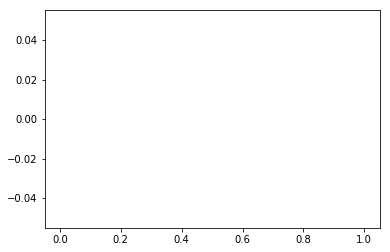

In [174]:
plt.hist(n_transits);

In [175]:
n_transits

[]

In [178]:
np.save('data/sim_obs/{0}.npy'.format(str(Time.now().datetime.time())), n_transits)

In [181]:
from subprocess import Popen

n_threads = 8
for i in range(n_threads): 
    Popen(['python', 'plan.py'], cwd='/Users/bmmorris/git/saint-stare/')